# Intel Image Classification using ResNet
### Deep Learning Course - Excercise 5
---
* **Student Name:** Daniela Slavutin
* **Date:** December 2025
* **Dataset:** [Intel Image Classification] (https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
---

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.ao.quantization.backend_config.executorch import executorch_weighted_op_int8_dtype_config
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# This code sets up libraries for working with CNNs, datasets, and visualization.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


## Preparing the Datasets

To ensure consistency across all experiments and avoid code duplication, we defined a centralized data augmentation pipeline before the training phase.

### Training Transformations:
* **`resize`:** Resized all images to a uniform resolution of 224x224 pixels.
* **`RandomHorizontalFlip`:** Randomly flips images horizontally to simulate different orientations.
* **`RandomRotation`:** Randomly rotated the images by up to 15 degrees.
* **`ColorJitter`:** Randomly adjusts brightness and contrast by a factor of 20% to simulate different lighting  conditions.
* **`ToTensor`:** Converting the images to PyTorch tensors from PIL format.
* **`Normalize`:** Normalizes tensor values by vectors of [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225] just as required to do when preparing our data for the ResNet model.

## Test Set Transformations:
For the test set, we applied only the essential transformations (`Resize`, `ToTensor` and `Normalize`) to ensure the evaluation reflects real-world performance on raw data without augmentation.


## Data Loading Strategy

We used the `torchvision.dataset.ImageFolder` class to make the data loading process much easier. Since the Intel Image dataset is organized in a standard hierarchical structure, `ImageFolder` allows us to:
1. **Automate Labeling:** Automatically infer class labels based on the folder names.
2. **Apply Transformations:** Seamlessly integrate the preprocessing and augmentation pipeline.

In [2]:
# Defining train transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Defining test transformations
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


In [3]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root="intel_image_dataset/seg_train", transform=transform_train)
test_dataset = ImageFolder(root="intel_image_dataset/seg_test", transform=transform_test)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


# Basic data about our train dataset
class_names = train_dataset.classes
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

print(f"Classes:{class_names}")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Image Size Check: {train_dataset[0][0].shape}")

Classes:['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Training set size: 14034
Test set size: 3000
Image Size Check: torch.Size([3, 224, 224])


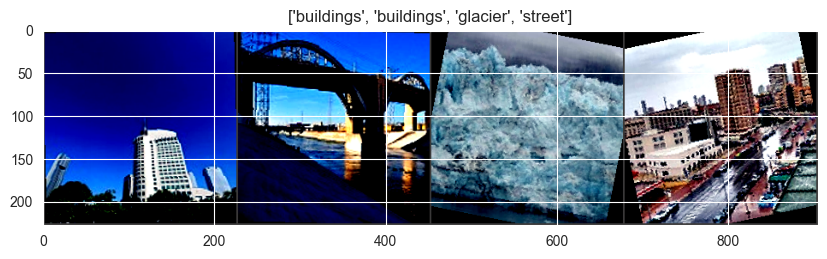

In [4]:
# Helper function to display images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = [0.485, 0.456, 0.406] * inp + [0.229, 0.224, 0.225]
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training images
inputs, classes = next(iter(train_loader))
# Creating presentation grid
out = torchvision.utils.make_grid(inputs[:4])

plt.figure(figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes[:4]])


## Loading and Preparing the ResNet18 Model
In this section we're loading a pretrained model of ResNet18, freezing its layer a replacing only the fully connected layer to a layer that will suit our 6-class-dataset.

In [5]:
# Loading a pretrained model of ResNet18
model = models.resnet18(pretrained=True)

# Freezing all layers of ResNet18
for param in model.parameters():
    param.requires_grad = False

# Replacing the fully connected layer
features_num = model.fc.in_features

# Replacing the last layer in an appropriate layer for our dataset (in our case it's gonna be a layer with 6 classes)
model.fc = nn.Linear(features_num, 6)

model = model.to(device)

print(f"Model read. Number of inputs to final layer: {features_num}")

C:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model read. Number of inputs to final layer: 512


## Defining Hyperparameters & Metrics + Creating the Training Function

Here we're defining our hyperparameters and creating the training function.

When defining the hyperparameters we're sending to the optimizer only the last layer parameters since most of the layer are frozen by requirements.

Differently than the training loops in exercise 4 we created a function that also calculates Recall, Precision and F1 for each epoch. Moreover, the function also saves the best model and saves the history of the training for the graphs later on.

As we could see, the best validation accuracy achieved here is 0.9037 which we achieved by the 9th epoch. This is much better than our costumed model in exercise 4 where our accuracy was around 78%~

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import time
import copy

criterion = nn.CrossEntropyLoss() # A standard function loss for classification

optimizer = optim.Adam(model.fc.parameters(), lr=0.001) # Using Adam optimizer to train only the fully connected layer

step_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Our function to train the model that also saves the best model, calculates all the metrics at the end of each epoch and returns the history to create graphs later
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': [] }

    data_loaders = {'train': train_loader, 'test': test_loader}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-'*10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            all_predictions = []
            all_labels = []

            # Iterate over data
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Stepping backwards and optimize only if we're in the train phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'test':
                    all_predictions.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            if phase == 'test':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
                recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
                f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

                history['val_precision'].append(precision)
                history['val_recall'].append(recall)
                history['val_f1'].append(f1)

                print(f"{phase} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}")

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_weights = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f} minutes, {time_elapsed % 60:.0f} seconds")
    print(f"Best val Accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_weights)
    return model, history


model, history = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.6506 Acc: 0.7934
test Loss: 0.3675 Acc: 0.8840
test Precision: 0.8840 Recall: 0.8840 F1: 0.8831

Epoch 2/10
----------
train Loss: 0.3777 Acc: 0.8742
test Loss: 0.3189 Acc: 0.8920
test Precision: 0.8932 Recall: 0.8920 F1: 0.8920

Epoch 3/10
----------
train Loss: 0.3433 Acc: 0.8814
test Loss: 0.2907 Acc: 0.8967
test Precision: 0.8965 Recall: 0.8967 F1: 0.8959

Epoch 4/10
----------
train Loss: 0.3272 Acc: 0.8857
test Loss: 0.2890 Acc: 0.8987
test Precision: 0.9001 Recall: 0.8987 F1: 0.8982

Epoch 5/10
----------
train Loss: 0.3261 Acc: 0.8826
test Loss: 0.2907 Acc: 0.9007
test Precision: 0.9035 Recall: 0.9007 F1: 0.9002

Epoch 6/10
----------
train Loss: 0.3134 Acc: 0.8883
test Loss: 0.2841 Acc: 0.9007
test Precision: 0.9035 Recall: 0.9007 F1: 0.9002

Epoch 7/10
----------
train Loss: 0.3080 Acc: 0.8874
test Loss: 0.2709 Acc: 0.9027
test Precision: 0.9026 Recall: 0.9027 F1: 0.9022

Epoch 8/10
----------
train Loss: 0.2868 Acc: 0.8963
test Loss: 0.270

## Fine Tuning Phase

In this phase we defreeze the rest of our ResNet18 layer in order to let it learn a little bit more and catch all of the nuances of the images.

Also we can see here that the best validation accuracy here is 0.9033, which is not better than the training phase presented here previously.

In [7]:
optimizer_ft = optim.Adam(model.fc.parameters(), lr=0.0001)

scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

print("Starting Fine-Tuning phase...")

model, history_ft = train_model(model, criterion, optimizer_ft, scheduler_ft, num_epochs=10)

Starting Fine-Tuning phase...
Epoch 1/10
----------
train Loss: 0.2919 Acc: 0.8939
test Loss: 0.2636 Acc: 0.9027
test Precision: 0.9022 Recall: 0.9027 F1: 0.9022

Epoch 2/10
----------
train Loss: 0.2928 Acc: 0.8966
test Loss: 0.2631 Acc: 0.9033
test Precision: 0.9032 Recall: 0.9033 F1: 0.9030

Epoch 3/10
----------
train Loss: 0.2991 Acc: 0.8915
test Loss: 0.2654 Acc: 0.9027
test Precision: 0.9022 Recall: 0.9027 F1: 0.9022

Epoch 4/10
----------
train Loss: 0.2904 Acc: 0.8948
test Loss: 0.2675 Acc: 0.9017
test Precision: 0.9012 Recall: 0.9017 F1: 0.9011

Epoch 5/10
----------
train Loss: 0.2859 Acc: 0.8965
test Loss: 0.2699 Acc: 0.8993
test Precision: 0.8990 Recall: 0.8993 F1: 0.8988

Epoch 6/10
----------
train Loss: 0.2865 Acc: 0.8975
test Loss: 0.2693 Acc: 0.8993
test Precision: 0.8990 Recall: 0.8993 F1: 0.8988

Epoch 7/10
----------
train Loss: 0.2873 Acc: 0.8972
test Loss: 0.2681 Acc: 0.9003
test Precision: 0.9001 Recall: 0.9003 F1: 0.8998

Epoch 8/10
----------
train Loss: 0.288

## Graphs and Results
Just as expected and desired, we can see here that validation accuracy is much higher than training accuracy, up untill we started the fine tuning - there we see that the validation accuracy and training accuracy are meeting at the same point.

By loss we can see that the validation loss is much lower than the training loss, and even much lower after the fine tuning process.

Also we see a the confusion matrix that we have much higher results of true positives! Compared to our customed model from exercise 4 where we had most of the true positives between 300 to 400.

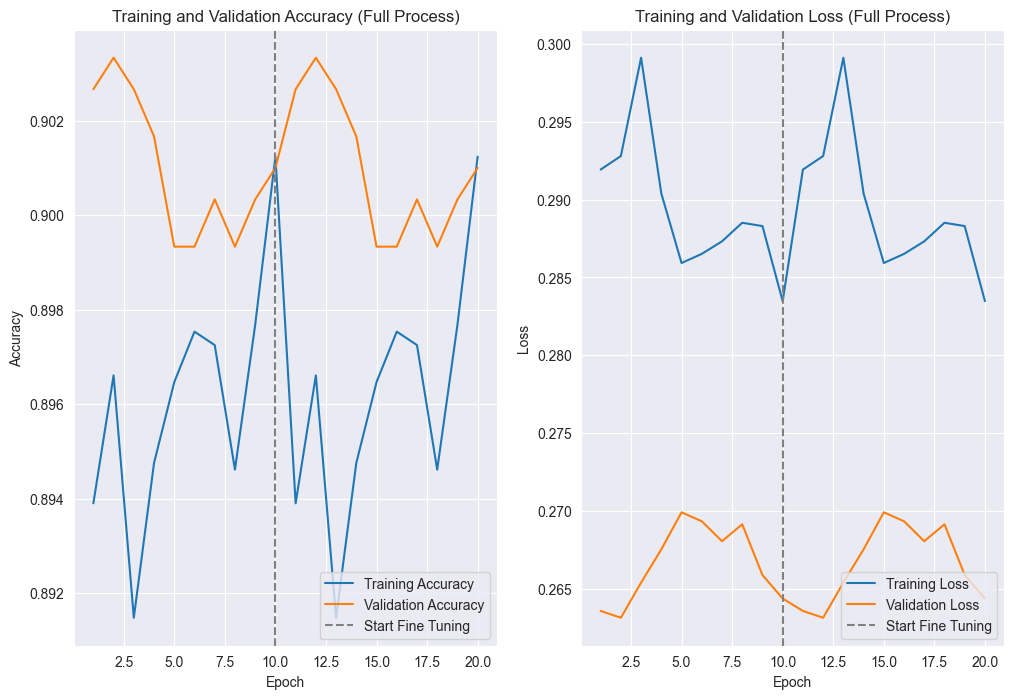

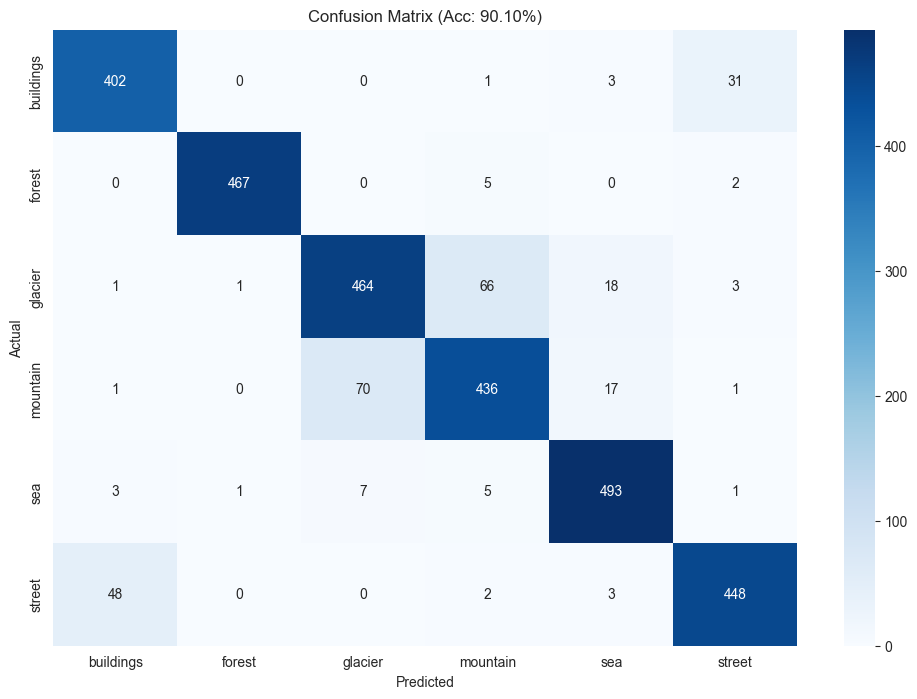

In [9]:
from sklearn.metrics import confusion_matrix

total_tr_acc = history_ft['train_acc'] + history_ft['train_acc']
total_val_acc = history_ft['val_acc'] + history_ft['val_acc']
total_tr_loss = history_ft['train_loss'] + history_ft['train_loss']
total_val_loss = history_ft['val_loss'] + history_ft['val_loss']

epochs_range = range(1, len(total_tr_acc) + 1)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, total_tr_acc, label='Training Accuracy')
plt.plot(epochs_range, total_val_acc, label='Validation Accuracy')
plt.axvline(x=len(history['train_acc']), color='gray', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Full Process)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, total_tr_loss, label='Training Loss')
plt.plot(epochs_range, total_val_loss, label='Validation Loss')
plt.axvline(x=len(history['train_loss']), color='gray', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss (Full Process)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

def plot_confusion_matrix(model, loader, device):
    all_predictions = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (Acc: {total_val_acc[-1]:.2%})')
    plt.show()

plot_confusion_matrix(model, test_loader, device)